## Home Credit Default Risk Prediction Model: EDA Notebook

In [1]:
from google.oauth2 import service_account
import pandas as pd
from skopt import BayesSearchCV
import json
import pandas_gbq
import numpy as np
from concurrent.futures import ThreadPoolExecutor
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.model_selection import  train_test_split, cross_val_score, StratifiedKFold
from sklearn.feature_selection import RFE
import xgboost as xgb
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn.metrics import f1_score, roc_auc_score, precision_score, recall_score, average_precision_score
import warnings
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
import os
import pickle
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve, auc
from sklearn.model_selection import learning_curve
from sklearn.metrics import precision_recall_curve
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
import scipy.stats as stats
from scipy.stats import chi2_contingency, ttest_ind, mannwhitneyu, normaltest
import statsmodels.api as sm
from itertools import combinations
warnings.filterwarnings('ignore')
from src.extract_load_data import BigQuery_DataOps
from src.exploration_funcs import automatic_feature_analysis
from src.feature_engineering import feature_engineering_production, feature_engineering_training
from src.model_functions import StackedModel

%matplotlib inline
pd.set_option('display.max_columns', None)

Importing the data available in production and creating the training and testing datasets from it and saving locally so the exploration process does not need to keep downloading the data from BigQuery.

In [2]:
df = BigQuery_DataOps(sub_db = 'prd').extract_data(tb_id = 'prd_analytical_base_table')

In [8]:
X = df.drop(["TARGET"], axis=1)
y = df[["TARGET"]]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=df["TARGET"])

training_data = pd.concat([X_train, y_train], axis=1)
testing_data = pd.concat([X_test, y_test], axis=1)
training_data.to_csv(r"C:\Users\artur\Documents\home_credit_model\data\training_data_nb.csv", index_label=False)
testing_data.to_csv(r"C:\Users\artur\Documents\home_credit_model\data\testing_data_nb.csv", index_label=False)

Reading the training dataset. We can check that the data is extremely imbalanced (92% of the data has the negative label)

In [2]:
df = pd.read_csv("data/training_data_nb.csv").reset_index(drop=True)

TARGET
0    0.919799
1    0.080201
Name: proportion, dtype: float64

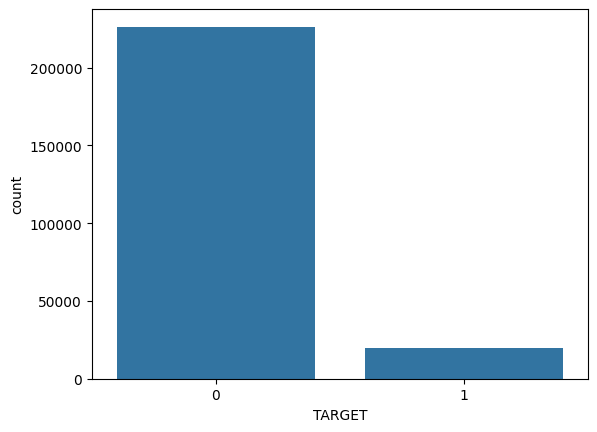

In [11]:
sns.barplot(df['TARGET'].value_counts())
df['TARGET'].value_counts(normalize=True)

In [12]:
df.head()

,SK_ID_CURR,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,NAME_CONTRACT_TYPE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,N_ACTIVE,N_SOLD,N_CLOSED,N_BADD,N_DICT_BUREAU_CREDS,MAX_DAYS_CREDIT,AVG_DAYS_CREDIT,MAX_CREDIT_DAY_OVERDUE,AVG_DAYS_CREDIT_ENDDATE,AVG_DAYS_ENDDATE_FACT,MAX_AMT_CREDIT_MAX_OVERDUE,AVG_AMT_CREDIT_MAX_OVERDUE,SUM_AMT_CREDIT_MAX_OVERDUE,MAX_CNT_CREDIT_PROLONG,AVG_AMT_CREDIT_SUM,MAX_AMT_CREDIT_SUM,SUM_AMT_CREDIT_SUM,AVG_AMT_CREDIT_SUM_DEBT,MAX_AMT_CREDIT_SUM_DEBT,SUM_AMT_CREDIT_SUM_DEBT,MAX_AMT_CREDIT_SUM_LIMIT,AVG_AMT_CREDIT_SUM_OVERDUE,MAX_AMT_CREDIT_SUM_OVERDUE,SUM_AMT_CREDIT_SUM_OVERDUE,AVG_AMT_AMT_ANNUITY,MAX_AMT_AMT_ANNUITY,SUM_AMT_AMT_ANNUITY,TARGET
0,100249,67500.0,76410.0,4513.5,67500.0,0.010500,-15293,-5317,-4699.0,-4753,NaN,1,1,1,1,0,0,Laborers,4.0,3,3,FRIDAY,15,0,0,0,0,1,1,Industry: type 3,0.636498,0.093445,0.519097,0.0340,NaN,0.9816,NaN,NaN,0.00,NaN,0.0833,NaN,NaN,NaN,0.0269,NaN,0.0000,0.0347,NaN,0.9816,NaN,NaN,0.0000,NaN,0.0833,NaN,NaN,NaN,0.0281,NaN,0.0000,0.0344,NaN,0.9816,NaN,NaN,0.00,NaN,0.0833,NaN,NaN,NaN,0.0274,NaN,0.0000,NaN,NaN,0.0212,"Stone, brick",No,0.0,0.0,0.0,0.0,-1655.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,1.0,0.0,F,N,Y,2.0,Cash loans,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,1.0,0.0,2.0,0.0,3.0,-550.0,-682.333333,0.0,-86.000000,-421.000000,NaN,NaN,NaN,0.0,117321.000000,270000.0,351963.00,1512.000000,4536.0,4536.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,0
1,274024,112500.0,720000.0,21181.5,720000.0,0.009334,-18721,365243,-6134.0,-2251,NaN,1,0,0,1,1,0,NaN,2.0,2,2,SUNDAY,10,0,0,0,0,0,0,XNA,0.832720,0.625494,0.634706,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-2000.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,2.0,2.0,F,N,Y,0.0,Cash loans,Una

Dropping duplicates in order to train the model afterwards.

In [13]:
int(df.duplicated().sum())

63789

In [14]:
df.drop_duplicates(inplace=True)

There's a lot of null data, spread across many different columns.

In [15]:
df.isnull().sum().sum()

np.int64(6585089)

In [16]:
df.isnull().sum()

SK_ID_CURR                         0
AMT_INCOME_TOTAL                   0
AMT_CREDIT                         0
AMT_ANNUITY                       10
AMT_GOODS_PRICE                  161
                               ...  
SUM_AMT_CREDIT_SUM_OVERDUE     25040
AVG_AMT_AMT_ANNUITY           134359
MAX_AMT_AMT_ANNUITY           134359
SUM_AMT_AMT_ANNUITY           134359
TARGET                             0
Length: 149, dtype: int64

Many of the columns are associated to the aggregated data from prd_bureau.

In [17]:
cols_cols = ["column_name", "n_rows_null"]
cols = pd.DataFrame(df.isnull().sum()).reset_index()
cols.columns = cols_cols

cols['total_rows'] = len(df)
cols['perc_null'] = (cols['n_rows_null'] / cols['total_rows']) * 100
cols.loc[(cols["n_rows_null"] > 0)].sort_values(by=["n_rows_null"], ascending=False).head(50)

,column_name,n_rows_null,total_rows,perc_null
147,SUM_AMT_AMT_ANNUITY,134359,182219,73.734901
146,MAX_AMT_AMT_ANNUITY,134359,182219,73.734901
145,AVG_AMT_AMT_ANNUITY,134359,182219,73.734901
65,COMMONAREA_MEDI,126950,182219,69.668915
37,COMMONAREA_AVG,126950,182219,69.668915
51,COMMONAREA_MODE,126950,182219,69.668915
45,NONLIVINGAPARTMENTS_AVG,126116,182219,69.211224
73,NONLIVINGAPARTMENTS_MEDI,126116,182219,69.211224
59,NONLIVINGAPARTMENTS_MODE,126116,182219,69.211224
75,FONDKAPREMONT_MODE,124300,182219,68.214621


Doing the same analysis focusing on categorical data.

In [18]:
string_cols = [c for c in list(df.columns) if df[c].dtype=='object']

cols.loc[(cols["n_rows_null"] > 0) & (cols['column_name'].isin(string_cols))].sort_values(by=["n_rows_null"], ascending=False).head(20)

,column_name,n_rows_null,total_rows,perc_null
75,FONDKAPREMONT_MODE,124300,182219,68.214621
78,WALLSMATERIAL_MODE,92023,182219,50.501320
76,HOUSETYPE_MODE,90811,182219,49.836186
79,EMERGENCYSTATE_MODE,85796,182219,47.084003
17,OCCUPATION_TYPE,57107,182219,31.339761
116,NAME_TYPE_SUITE,776,182219,0.425861


Creating our first function to perform the initial data cleaning steps.

In [3]:
def first_data_cleaning(df):
    
    df.drop_duplicates(inplace=True)
    string_cols = [c for c in list(df.columns) if df[c].dtype=='object']

    for i in df.columns:
        if df[i].name in string_cols:
            df[i] = np.where(df[i].isnull(), 'No Data', df[i])
        else:
            df[i] = np.where(df[i].isnull(), 0, df[i])
    
    return df
    

In [4]:
df2 = first_data_cleaning(df)

In [23]:
df2.head()

,SK_ID_CURR,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,NAME_CONTRACT_TYPE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,N_ACTIVE,N_SOLD,N_CLOSED,N_BADD,N_DICT_BUREAU_CREDS,MAX_DAYS_CREDIT,AVG_DAYS_CREDIT,MAX_CREDIT_DAY_OVERDUE,AVG_DAYS_CREDIT_ENDDATE,AVG_DAYS_ENDDATE_FACT,MAX_AMT_CREDIT_MAX_OVERDUE,AVG_AMT_CREDIT_MAX_OVERDUE,SUM_AMT_CREDIT_MAX_OVERDUE,MAX_CNT_CREDIT_PROLONG,AVG_AMT_CREDIT_SUM,MAX_AMT_CREDIT_SUM,SUM_AMT_CREDIT_SUM,AVG_AMT_CREDIT_SUM_DEBT,MAX_AMT_CREDIT_SUM_DEBT,SUM_AMT_CREDIT_SUM_DEBT,MAX_AMT_CREDIT_SUM_LIMIT,AVG_AMT_CREDIT_SUM_OVERDUE,MAX_AMT_CREDIT_SUM_OVERDUE,SUM_AMT_CREDIT_SUM_OVERDUE,AVG_AMT_AMT_ANNUITY,MAX_AMT_AMT_ANNUITY,SUM_AMT_AMT_ANNUITY,TARGET
0,100249,67500.0,76410.0,4513.5,67500.0,0.010500,-15293,-5317,-4699.0,-4753,0.0,1,1,1,1,0,0,Laborers,4.0,3,3,FRIDAY,15,0,0,0,0,1,1,Industry: type 3,0.636498,0.093445,0.519097,0.0340,0.0000,0.9816,0.0000,0.0000,0.00,0.0000,0.0833,0.0000,0.0000,0.0000,0.0269,0.0000,0.0000,0.0347,0.0000,0.9816,0.0000,0.0000,0.0000,0.0000,0.0833,0.0000,0.0000,0.0000,0.0281,0.0000,0.0000,0.0344,0.0000,0.9816,0.0000,0.0000,0.00,0.0000,0.0833,0.0000,0.0000,0.0000,0.0274,0.0000,0.0000,No Data,No Data,0.0212,"Stone, brick",No,0.0,0.0,0.0,0.0,-1655.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,1.0,0.0,F,N,Y,2.0,Cash loans,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,1.0,0.0,2.0,0.0,3.0,-550.0,-682.333333,0.0,-86.000000,-421.000000,0.0,0.000,0.000,0.0,117321.000000,270000.0,351963.00,1512.000000,4536.0,4536.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0
1,274024,112500.0,720000.0,21181.5,720000.0,0.009334,-18721,365243,-6134.0,-2251,0.0,1,0,0,1,1,0,No Data,2.0,2,2,SUNDAY,10,0,0,0,0,0,0,XNA,0.832720,0.625494,0.634706,0.0000,0.0000,0.0000,0.0000,0.0000,0.00,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000

In [24]:
print(len(df2.columns))
print(len(df.columns))

149
149


## Feature Engineering

The cells below use a function imported from src.exploration_funcs.py module that performs analysis on the categorical features and how their respective categories differentiate from one another in terms of the proportion of the TARGET column: are some categories associated with a higher occurence of default (TARGET = 1)? 

In every case, a Chi-Squared test was performed to check if, with a 95% confidence level, there was association involved with the categories and the TARGET categories (1 and 0).

Automatic Analysis Report for TARGET: TARGET

Analyzing Categorical Feature: OCCUPATION_TYPE
------------------------------------------------------------
Proportions of TARGET within each category:
TARGET                        0         1
OCCUPATION_TYPE                          
Accountants            0.951359  0.048641
Cleaning staff         0.902201  0.097799
Cooking staff          0.895786  0.104214
Core staff             0.937707  0.062293
Drivers                0.888627  0.111373
HR staff               0.925501  0.074499
High skill tech staff  0.936330  0.063670
IT staff               0.923780  0.076220
Laborers               0.895213  0.104787
Low-skill Laborers     0.837037  0.162963
Managers               0.936412  0.063588
Medicine staff         0.932254  0.067746
No Data                0.935612  0.064388
Private service staff  0.933626  0.066374
Realty agents          0.930886  0.069114
Sales staff            0.904167  0.095833
Secretaries            0.924359  0.075641
Secu

<Figure size 2000x1000 with 0 Axes>

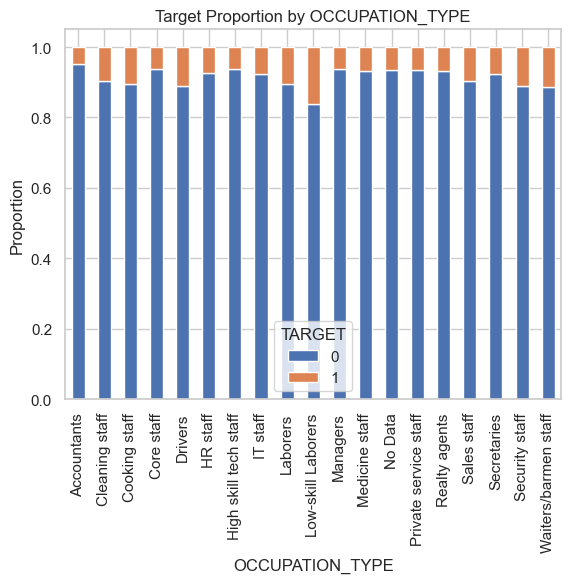

Chi-square test p-value: 5.161618239120147e-226
Significant relationship detected between OCCUPATION_TYPE and TARGET (p < 0.05).

Analyzing Categorical Feature: WEEKDAY_APPR_PROCESS_START
------------------------------------------------------------
Proportions of TARGET within each category:
TARGET                             0         1
WEEKDAY_APPR_PROCESS_START                    
FRIDAY                      0.919404  0.080596
MONDAY                      0.922228  0.077772
SATURDAY                    0.921971  0.078029
SUNDAY                      0.920151  0.079849
THURSDAY                    0.920127  0.079873
TUESDAY                     0.915607  0.084393
WEDNESDAY                   0.919446  0.080554


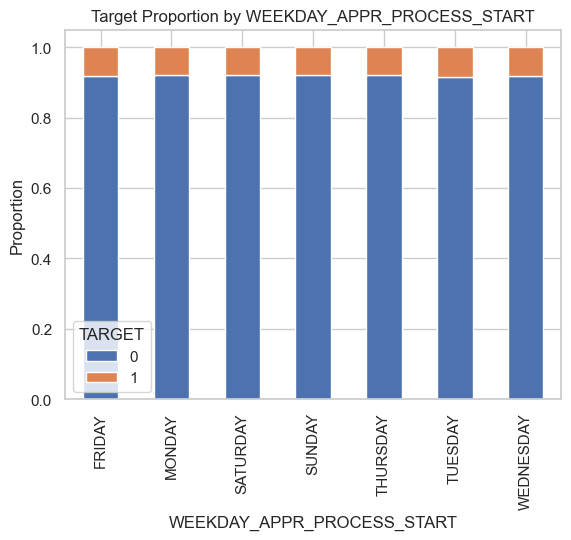

Chi-square test p-value: 0.07696741536925449
No significant relationship detected between WEEKDAY_APPR_PROCESS_START and TARGET (p >= 0.05).

Analyzing Categorical Feature: ORGANIZATION_TYPE
------------------------------------------------------------
Proportions of TARGET within each category:
TARGET                         0         1
ORGANIZATION_TYPE                         
Advertising             0.921162  0.078838
Agriculture             0.899367  0.100633
Bank                    0.947981  0.052019
Business Entity Type 1  0.916100  0.083900
Business Entity Type 2  0.916454  0.083546
Business Entity Type 3  0.907651  0.092349
Cleaning                0.868966  0.131034
Construction            0.885015  0.114985
Culture                 0.959091  0.040909
Electricity             0.928571  0.071429
Emergency               0.935484  0.064516
Government              0.929751  0.070249
Hotel                   0.941176  0.058824
Housing                 0.916428  0.083572
Industry: type 1

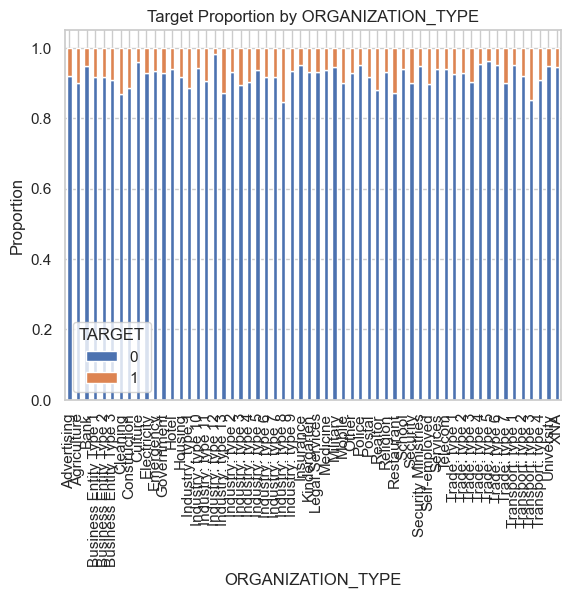


Analyzing Categorical Feature: FONDKAPREMONT_MODE
------------------------------------------------------------
Proportions of TARGET within each category:
TARGET                        0         1
FONDKAPREMONT_MODE                       
No Data                0.914240  0.085760
not specified          0.924095  0.075905
org spec account       0.939032  0.060968
reg oper account       0.930666  0.069334
reg oper spec account  0.934687  0.065313


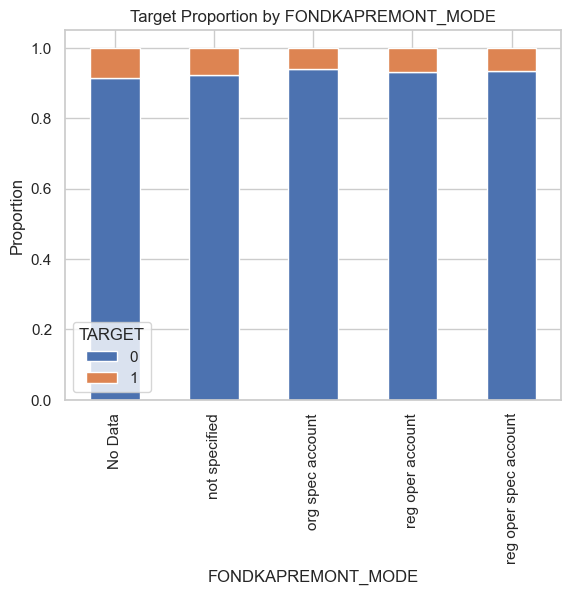

Chi-square test p-value: 7.108094420335342e-34
Significant relationship detected between FONDKAPREMONT_MODE and TARGET (p < 0.05).

Analyzing Categorical Feature: HOUSETYPE_MODE
------------------------------------------------------------
Proportions of TARGET within each category:
TARGET                   0         1
HOUSETYPE_MODE                      
No Data           0.908678  0.091322
block of flats    0.930823  0.069177
specific housing  0.906874  0.093126
terraced house    0.926407  0.073593


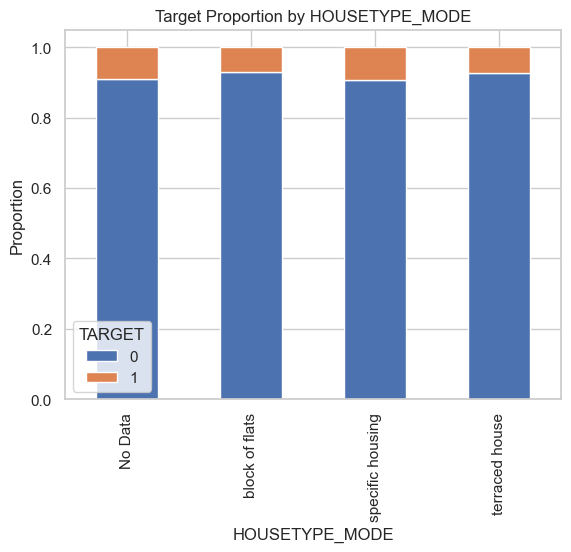

Chi-square test p-value: 3.516190608266786e-65
Significant relationship detected between HOUSETYPE_MODE and TARGET (p < 0.05).

Analyzing Categorical Feature: WALLSMATERIAL_MODE
------------------------------------------------------------
Proportions of TARGET within each category:
TARGET                     0         1
WALLSMATERIAL_MODE                    
Block               0.932146  0.067854
Mixed               0.930316  0.069684
Monolithic          0.952741  0.047259
No Data             0.908827  0.091173
Others              0.920668  0.079332
Panel               0.936696  0.063304
Stone, brick        0.926381  0.073619
Wooden              0.901955  0.098045


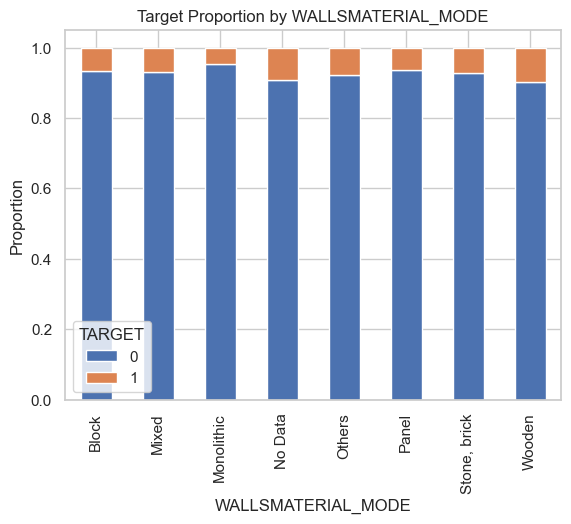

Chi-square test p-value: 2.0993986186806157e-75
Significant relationship detected between WALLSMATERIAL_MODE and TARGET (p < 0.05).

Analyzing Categorical Feature: EMERGENCYSTATE_MODE
------------------------------------------------------------
Proportions of TARGET within each category:
TARGET                      0         1
EMERGENCYSTATE_MODE                    
No                   0.930896  0.069104
No Data              0.907502  0.092498
Yes                  0.900862  0.099138


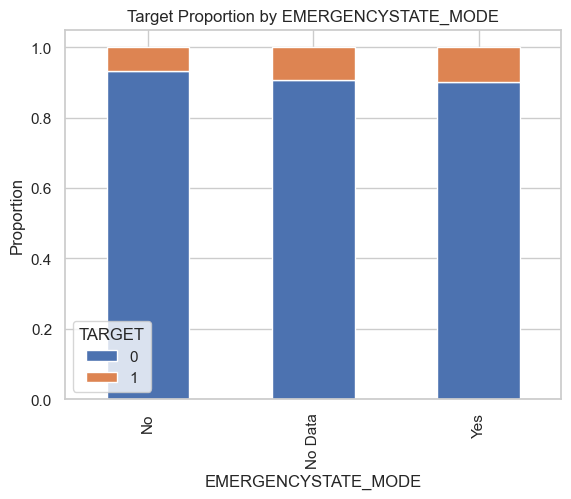

Chi-square test p-value: 1.0581587355080675e-74
Significant relationship detected between EMERGENCYSTATE_MODE and TARGET (p < 0.05).

Analyzing Categorical Feature: CODE_GENDER
------------------------------------------------------------
Proportions of TARGET within each category:
TARGET              0         1
CODE_GENDER                    
F            0.930168  0.069832
M            0.899370  0.100630
XNA          1.000000  0.000000


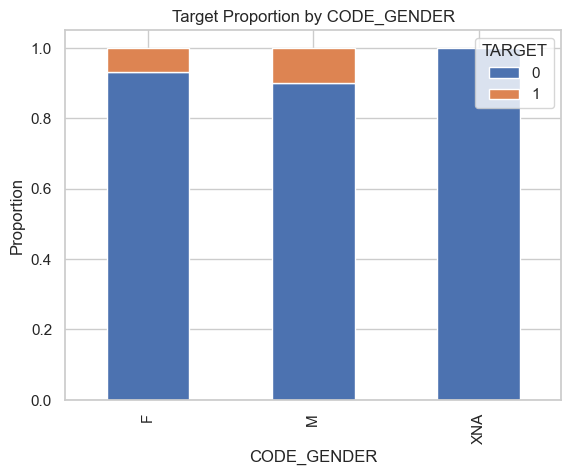


Analyzing Categorical Feature: FLAG_OWN_CAR
------------------------------------------------------------
Proportions of TARGET within each category:
TARGET               0         1
FLAG_OWN_CAR                    
N             0.915068  0.084932
Y             0.928517  0.071483


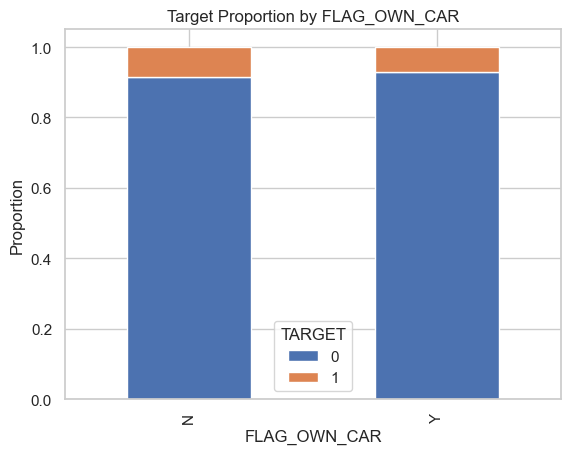

Chi-square test p-value: 1.5057840603720877e-23
Significant relationship detected between FLAG_OWN_CAR and TARGET (p < 0.05).

Analyzing Categorical Feature: FLAG_OWN_REALTY
------------------------------------------------------------
Proportions of TARGET within each category:
TARGET                  0         1
FLAG_OWN_REALTY                    
N                0.917765  0.082235
Y                0.920486  0.079514


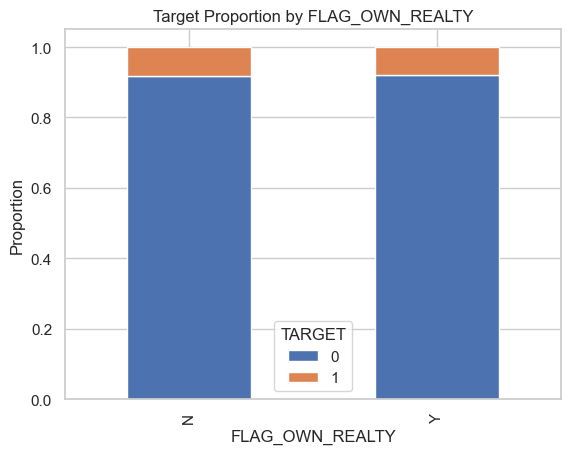

Chi-square test p-value: 0.04985738722301858
Significant relationship detected between FLAG_OWN_REALTY and TARGET (p < 0.05).

Analyzing Categorical Feature: NAME_CONTRACT_TYPE
------------------------------------------------------------
Proportions of TARGET within each category:
TARGET                     0         1
NAME_CONTRACT_TYPE                    
Cash loans          0.917023  0.082977
Revolving loans     0.944604  0.055396


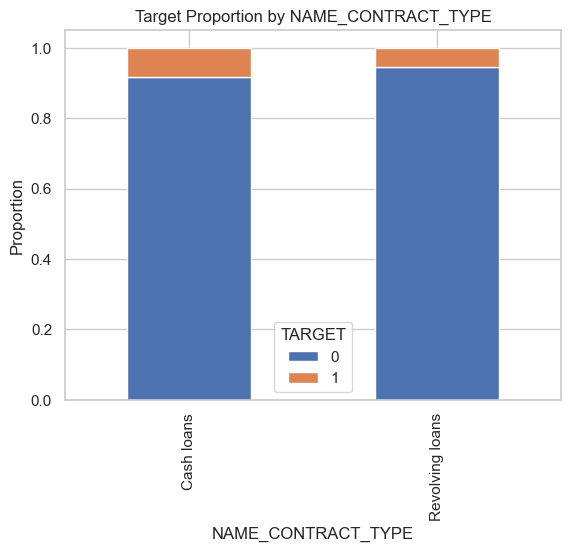

Chi-square test p-value: 5.671084817499738e-37
Significant relationship detected between NAME_CONTRACT_TYPE and TARGET (p < 0.05).

Analyzing Categorical Feature: NAME_TYPE_SUITE
------------------------------------------------------------
Proportions of TARGET within each category:
TARGET                  0         1
NAME_TYPE_SUITE                    
Children         0.928645  0.071355
Family           0.924792  0.075208
Group of people  0.924528  0.075472
No Data          0.954897  0.045103
Other_A          0.915709  0.084291
Other_B          0.892821  0.107179
Spouse, partner  0.922895  0.077105
Unaccompanied    0.918554  0.081446


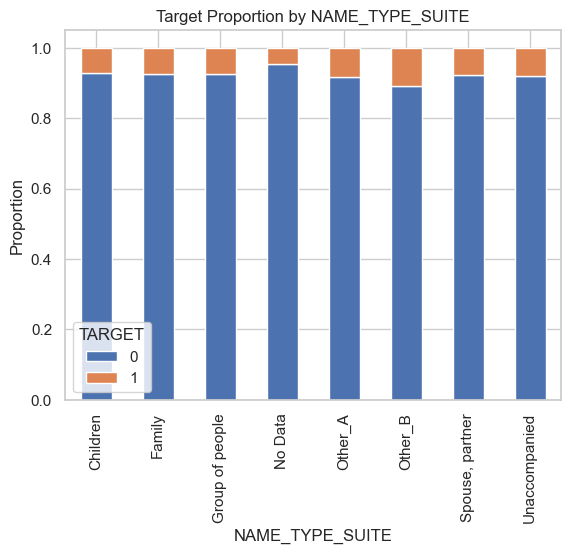

Chi-square test p-value: 5.003738129331958e-06
Significant relationship detected between NAME_TYPE_SUITE and TARGET (p < 0.05).

Analyzing Categorical Feature: NAME_INCOME_TYPE
------------------------------------------------------------
Proportions of TARGET within each category:
TARGET                       0         1
NAME_INCOME_TYPE                        
Businessman           1.000000  0.000000
Commercial associate  0.925752  0.074248
Maternity leave       1.000000  0.000000
Pensioner             0.946420  0.053580
State servant         0.943065  0.056935
Student               1.000000  0.000000
Unemployed            0.636364  0.363636
Working               0.904382  0.095618


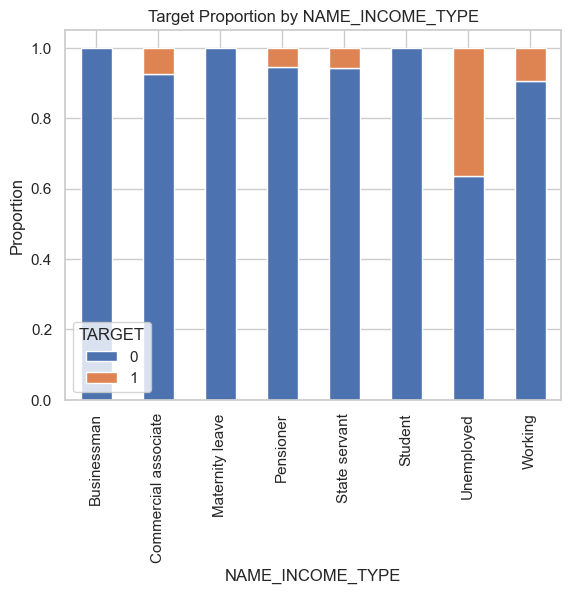


Analyzing Categorical Feature: NAME_EDUCATION_TYPE
------------------------------------------------------------
Proportions of TARGET within each category:
TARGET                                0         1
NAME_EDUCATION_TYPE                              
Academic degree                0.978022  0.021978
Higher education               0.946718  0.053282
Incomplete higher              0.915736  0.084264
Lower secondary                0.889181  0.110819
Secondary / secondary special  0.910974  0.089026


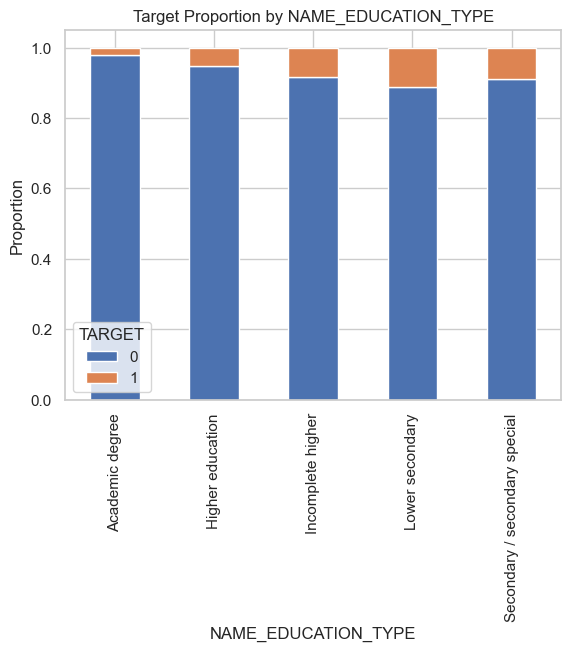


Analyzing Categorical Feature: NAME_FAMILY_STATUS
------------------------------------------------------------
Proportions of TARGET within each category:
TARGET                       0         1
NAME_FAMILY_STATUS                      
Civil marriage        0.900188  0.099812
Married               0.924906  0.075094
Separated             0.920085  0.079915
Single / not married  0.900899  0.099101
Unknown               1.000000  0.000000
Widow                 0.943454  0.056546


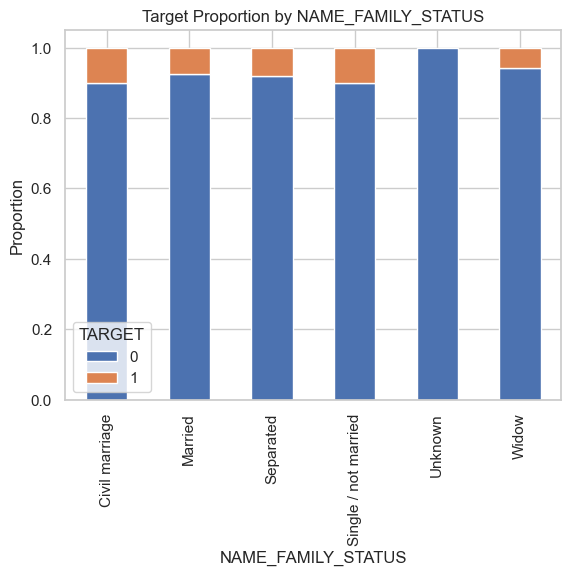


Analyzing Categorical Feature: NAME_HOUSING_TYPE
------------------------------------------------------------
Proportions of TARGET within each category:
TARGET                      0         1
NAME_HOUSING_TYPE                      
Co-op apartment      0.930618  0.069382
House / apartment    0.922430  0.077570
Municipal apartment  0.912958  0.087042
Office apartment     0.928525  0.071475
Rented apartment     0.873544  0.126456
With parents         0.886293  0.113707


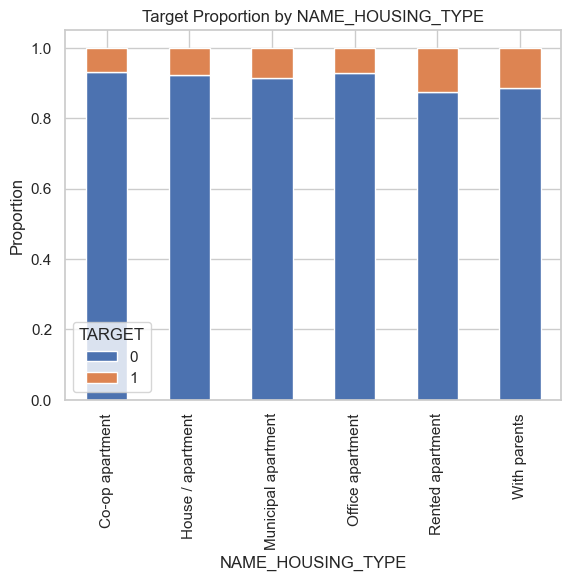

Chi-square test p-value: 1.1992162302847478e-49
Significant relationship detected between NAME_HOUSING_TYPE and TARGET (p < 0.05).


In [25]:
automatic_feature_analysis(df2)

After the results of the study above, some insights can be taken:

1) ORGANIZATION_TYPE has a lot of categories, some with too few data points, causing the Chi-Square test to not be applicable. So, the approach of associating the ORGANIZATION_TYPE categories that have an occurrence of more than 10% of default clients to a category (1) and the rest to another category (0) was taken, reducing the cardinality of the feature;

2) REGION_RATING_CLIENT and REGION_RATING_CLIENT_W_CITY are in fact categorical, but in likert scale, which pandas inferred as numeric. We need to convert it to object type;

3) CODE_GENDER was converted to 1 (M) or 0 (else);

4) NAME_INCOME_TYPE, according to the study, has significantly more clients with default in the "Unemployed" category (which makes absolute sense). Let's aggregate this feature to Unemployed (1) or not (0), reducing cardinality and improving information separation. The same line of thought was applied to NAME_EDUCATION_TYPE, but in the sense that clients with Academic Degree or Higher Education have lower occurrence of default than the rest of the categories.

In [26]:
organization_type_df = pd.crosstab(df2['ORGANIZATION_TYPE'], df2['TARGET'], normalize='index').reset_index()
organization_type_df.columns = ['ORGANIZATION_TYPE', '0', '1']
organization_type_list = organization_type_df.loc[organization_type_df["1"] > 0.1]['ORGANIZATION_TYPE'].tolist()

df2["REGION_RATING_CLIENT"] = df2["REGION_RATING_CLIENT"].astype(object)
df2["REGION_RATING_CLIENT_W_CITY"] = df2["REGION_RATING_CLIENT_W_CITY"].astype(object)

new_df_cat = df2[['ORGANIZATION_TYPE', 'CODE_GENDER', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'TARGET']]
new_df_cat['ORGANIZATION_TYPE'] = np.where(new_df_cat['ORGANIZATION_TYPE'].isin(organization_type_list), '1', '0')
new_df_cat['CODE_GENDER'] = np.where(new_df_cat['CODE_GENDER'].isin(['M']), '1', '0')
new_df_cat['NAME_INCOME_TYPE'] = np.where(new_df_cat['NAME_INCOME_TYPE'].isin(['Unemployed']), '1', '0')
new_df_cat['NAME_EDUCATION_TYPE'] = np.where(new_df_cat['NAME_EDUCATION_TYPE'].isin(['Academic degree', 'Higher education']), '1', '0')


After this initial feature engineering process, let's redo the previous study.

Automatic Analysis Report for TARGET: TARGET

Analyzing Categorical Feature: ORGANIZATION_TYPE
------------------------------------------------------------
Proportions of TARGET within each category:
TARGET                    0         1
ORGANIZATION_TYPE                    
0                  0.925415  0.074585
1                  0.893326  0.106674


<Figure size 2000x1000 with 0 Axes>

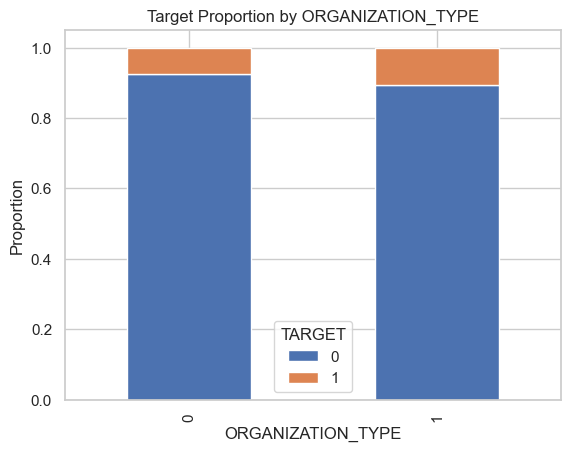

Chi-square test p-value: 2.951019267940066e-83
Significant relationship detected between ORGANIZATION_TYPE and TARGET (p < 0.05).

Analyzing Categorical Feature: CODE_GENDER
------------------------------------------------------------
Proportions of TARGET within each category:
TARGET             0        1
CODE_GENDER                  
0            0.93017  0.06983
1            0.89937  0.10063


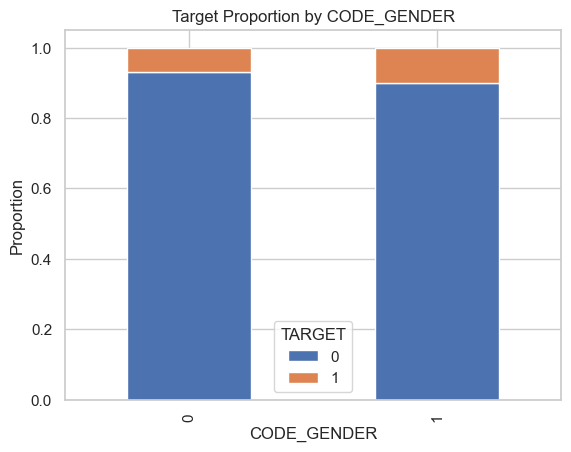

Chi-square test p-value: 2.507555654432385e-116
Significant relationship detected between CODE_GENDER and TARGET (p < 0.05).

Analyzing Categorical Feature: NAME_INCOME_TYPE
------------------------------------------------------------
Proportions of TARGET within each category:
TARGET                   0         1
NAME_INCOME_TYPE                    
0                 0.919669  0.080331
1                 0.636364  0.363636


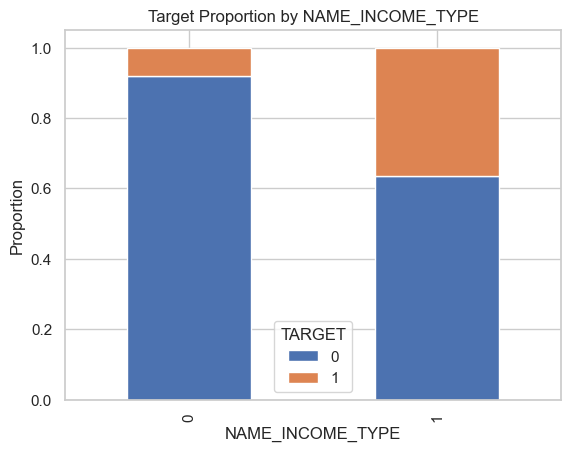


Analyzing Categorical Feature: NAME_EDUCATION_TYPE
------------------------------------------------------------
Proportions of TARGET within each category:
TARGET                      0         1
NAME_EDUCATION_TYPE                    
0                    0.910823  0.089177
1                    0.946781  0.053219


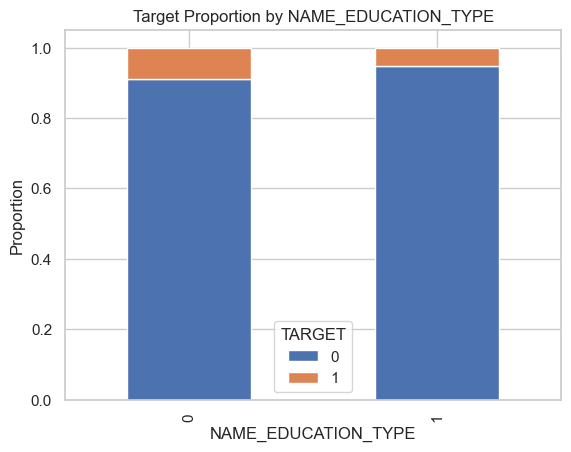

Chi-square test p-value: 2.2850822218304155e-130
Significant relationship detected between NAME_EDUCATION_TYPE and TARGET (p < 0.05).

Analyzing Categorical Feature: REGION_RATING_CLIENT
------------------------------------------------------------
Proportions of TARGET within each category:
TARGET                       0         1
REGION_RATING_CLIENT                    
1                     0.952945  0.047055
2                     0.921543  0.078457
3                     0.888532  0.111468


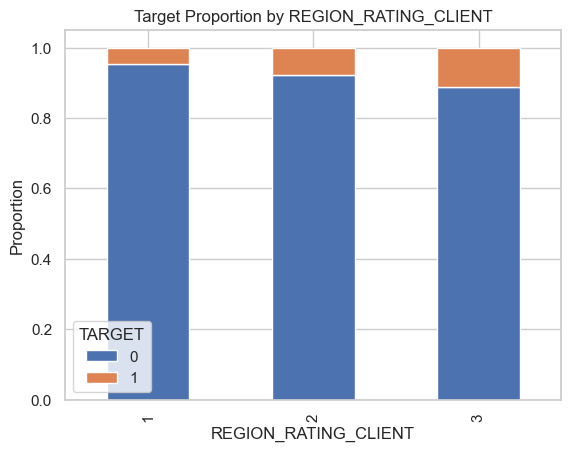

Chi-square test p-value: 4.6445693918705575e-146
Significant relationship detected between REGION_RATING_CLIENT and TARGET (p < 0.05).

Analyzing Categorical Feature: REGION_RATING_CLIENT_W_CITY
------------------------------------------------------------
Proportions of TARGET within each category:
TARGET                              0         1
REGION_RATING_CLIENT_W_CITY                    
1                            0.952963  0.047037
2                            0.921178  0.078822
3                            0.885644  0.114356


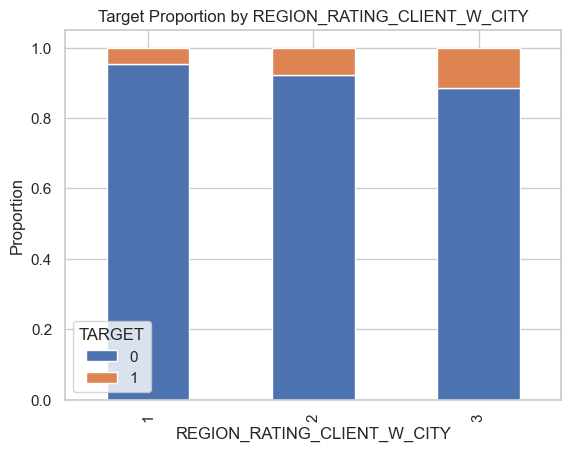

Chi-square test p-value: 3.4383399662139815e-156
Significant relationship detected between REGION_RATING_CLIENT_W_CITY and TARGET (p < 0.05).


In [27]:
automatic_feature_analysis(new_df_cat)

After the results above, one can see that WEEKDAY_APPR_PROCESS_START did not show any association with TARGET. Also, NAME_INCOME_TYPE and NAME_FAMILY_STATUS have a way to imbalanced category distribution regarding TARGET, which also justifies removing them from the model now.

In [28]:
new_df_cat['NAME_INCOME_TYPE'].value_counts()

NAME_INCOME_TYPE
0    182208
1        11
Name: count, dtype: int64

In [5]:
cat_cols_to_drop = ['NAME_INCOME_TYPE', 'WEEKDAY_APPR_PROCESS_START', 'NAME_FAMILY_STATUS']

Our second feature engineering function that performs the transformation between the studies above.

In [6]:
def cat_engineer(df, cat_cols_to_drop):
    if 'ORGANIZATION_TYPE' not in cat_cols_to_drop:
        organization_type_df = pd.crosstab(df['ORGANIZATION_TYPE'], df['TARGET'], normalize='index').reset_index()
        organization_type_df.columns = ['ORGANIZATION_TYPE', '0', '1']
        organization_type_list = organization_type_df.loc[organization_type_df["1"] > 0.1]['ORGANIZATION_TYPE'].tolist()
        df['ORGANIZATION_TYPE'] = np.where(df['ORGANIZATION_TYPE'].isin(organization_type_list), 1, 0)
    
    df["REGION_RATING_CLIENT"] = df["REGION_RATING_CLIENT"].astype(object)
    df["REGION_RATING_CLIENT_W_CITY"] = df["REGION_RATING_CLIENT_W_CITY"].astype(object)
    df['CODE_GENDER'] = np.where(df['CODE_GENDER'].isin(['M']), 1, 0)
    df['NAME_EDUCATION_TYPE'] = np.where(df['NAME_EDUCATION_TYPE'].isin(['Academic degree', 'Higher education']), 1, 0)
    df = df.drop(columns=cat_cols_to_drop)
    df.reset_index(drop=True, inplace=True)

    return df


In [7]:
df3 = cat_engineer(df2, cat_cols_to_drop)

In [32]:
df3.head(10)

,SK_ID_CURR,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,NAME_CONTRACT_TYPE,NAME_TYPE_SUITE,NAME_EDUCATION_TYPE,NAME_HOUSING_TYPE,N_ACTIVE,N_SOLD,N_CLOSED,N_BADD,N_DICT_BUREAU_CREDS,MAX_DAYS_CREDIT,AVG_DAYS_CREDIT,MAX_CREDIT_DAY_OVERDUE,AVG_DAYS_CREDIT_ENDDATE,AVG_DAYS_ENDDATE_FACT,MAX_AMT_CREDIT_MAX_OVERDUE,AVG_AMT_CREDIT_MAX_OVERDUE,SUM_AMT_CREDIT_MAX_OVERDUE,MAX_CNT_CREDIT_PROLONG,AVG_AMT_CREDIT_SUM,MAX_AMT_CREDIT_SUM,SUM_AMT_CREDIT_SUM,AVG_AMT_CREDIT_SUM_DEBT,MAX_AMT_CREDIT_SUM_DEBT,SUM_AMT_CREDIT_SUM_DEBT,MAX_AMT_CREDIT_SUM_LIMIT,AVG_AMT_CREDIT_SUM_OVERDUE,MAX_AMT_CREDIT_SUM_OVERDUE,SUM_AMT_CREDIT_SUM_OVERDUE,AVG_AMT_AMT_ANNUITY,MAX_AMT_AMT_ANNUITY,SUM_AMT_AMT_ANNUITY,TARGET
0,100249,67500.0,76410.0,4513.5,67500.0,0.010500,-15293,-5317,-4699.0,-4753,0.0,1,1,1,1,0,0,Laborers,4.0,3,3,15,0,0,0,0,1,1,1,0.636498,0.093445,0.519097,0.0340,0.0000,0.9816,0.0000,0.0000,0.00,0.0000,0.0833,0.0000,0.0000,0.0000,0.0269,0.0000,0.0000,0.0347,0.0000,0.9816,0.0000,0.0000,0.0000,0.0000,0.0833,0.0000,0.0000,0.0000,0.0281,0.0000,0.0000,0.0344,0.0000,0.9816,0.0000,0.0000,0.00,0.0000,0.0833,0.0000,0.0000,0.0000,0.0274,0.0000,0.0000,No Data,No Data,0.0212,"Stone, brick",No,0.0,0.0,0.0,0.0,-1655.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,1.0,0.0,0,N,Y,2.0,Cash loans,Unaccompanied,0,House / apartment,1.0,0.0,2.0,0.0,3.0,-550.0,-682.333333,0.0,-86.000000,-421.000000,0.00,0.000,0.000,0.0,1.173210e+05,270000.0,351963.000,1512.000000,4536.0,4536.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0
1,274024,112500.0,720000.0,21181.5,720000.0,0.009334,-18721,365243,-6134.0,-2251,0.0,1,0,0,1,1,0,No Data,2.0,2,2,10,0,0,0,0,0,0,0,0.832720,0.625494,0.634706,0.0000,0.0000,0.0000,0.0000,0.0000,0.00,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.00,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,No Data,No Data,0.0000,No Data,No Data,0.0,0.0,0.0,0.0

In [33]:
string_cols = [c for c in list(df3.columns) if df3[c].dtype=='object']

df3[string_cols].head()

,OCCUPATION_TYPE,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,FONDKAPREMONT_MODE,HOUSETYPE_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,FLAG_OWN_CAR,FLAG_OWN_REALTY,NAME_CONTRACT_TYPE,NAME_TYPE_SUITE,NAME_HOUSING_TYPE
0,Laborers,3,3,No Data,No Data,"Stone, brick",No,N,Y,Cash loans,Unaccompanied,House / apartment
1,No Data,2,2,No Data,No Data,No Data,No Data,N,Y,Cash loans,Unaccompanied,House / apartment
2,Sales staff,2,2,No Data,No Data,No Data,No Data,N,Y,Cash loans,Unaccompanied,House / apartment
3,Core staff,2,2,No Data,block of flats,Panel,No,N,Y,Cash loans,Family,House / apartment
4,High skill tech staff,3,3,No Data,block of flats,"Stone, brick",No,N,Y,Cash loans,Unaccompanied,House / apartment


After performig these initial analysis and feature engineering, let's proceed with detecting important features. For such, we will be using RFE method along with changing the number of features we want to extract in multiples of N where N is the number of features after the application of OneHotEncoding to the categorical features.

In [34]:
features = [c for c in df3.columns if c not in ['TARGET', 'SK_ID_CURR']]

string_cols = [c for c in list(df3.columns) if df3[c].dtype=='object']

X = df3[features]
y = df3["TARGET"]

In [35]:
comb_vector = []
metrics_vector = []

ratio = float(y.value_counts()[0] / y.value_counts()[1])

columns_trans = ColumnTransformer(
    transformers=[
        ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first'), string_cols)
    ],
    remainder='passthrough'
)

pipeline = Pipeline(steps=[
    ('preprocessor', columns_trans),
    ('classifier', xgb.XGBClassifier(scale_pos_weight=ratio))
])

pipeline.named_steps['preprocessor'].fit(X)
feature_names = pipeline.named_steps['preprocessor'].get_feature_names_out()

for i in range(7):
    j = i + 1
    print("===============")
    
    rfe = RFE(
        estimator=pipeline.named_steps['classifier'], 
        n_features_to_select=int(len(feature_names) / j)
    )
    
    X_transformed = pipeline.named_steps['preprocessor'].transform(X)
    
    print(f"start fitting RFE for {int(len(feature_names) / j)} features")
    rfeFit = rfe.fit(X_transformed, y)
    print(f"finish fitting RFE for {int(len(feature_names) / j)} features")

    selected_features_mask = rfeFit.support_
    j_features = feature_names[selected_features_mask]
    comb_vector.append(j_features)

    kfold = StratifiedKFold(n_splits=3)
    print(f"start fitting cv for {int(len(feature_names) / j)} features")

    X_selected = X_transformed[:, selected_features_mask]
    cv_results = cross_val_score(pipeline.named_steps['classifier'], X_selected, y, cv=kfold, scoring='average_precision')
    
    print(f"finish fitting cv for {int(len(feature_names) / j)} features")

    metrics_vector.append(np.mean(np.array(cv_results)))

    print("===============")


start fitting RFE for 185 features
finish fitting RFE for 185 features
start fitting cv for 185 features
finish fitting cv for 185 features
start fitting RFE for 92 features
finish fitting RFE for 92 features
start fitting cv for 92 features
finish fitting cv for 92 features
start fitting RFE for 61 features
finish fitting RFE for 61 features
start fitting cv for 61 features
finish fitting cv for 61 features
start fitting RFE for 46 features
finish fitting RFE for 46 features
start fitting cv for 46 features
finish fitting cv for 46 features
start fitting RFE for 37 features
finish fitting RFE for 37 features
start fitting cv for 37 features
finish fitting cv for 37 features
start fitting RFE for 30 features
finish fitting RFE for 30 features
start fitting cv for 30 features
finish fitting cv for 30 features
start fitting RFE for 26 features
finish fitting RFE for 26 features
start fitting cv for 26 features
finish fitting cv for 26 features


In [36]:
rfe_results = pd.DataFrame(list(zip([int(len(feature_names)/j) for j in range(1, 8)], [float(i) for i in metrics_vector])), columns=['n_features', 'average_precision'])

We used, here, the area under precision-recall curve to assess the performance of each model (features selected) with stratified cross-validation. This metric was chosen in order to check if the features combinations have different performances on detecting the positive outputs correctly.

The results below show that varying the features (from all of them to the 26 best ones), did not cause major differences between performances regarding the area under precision-recall curve. Even so, for challenge purposes, let's proceed with all features, although we could simply proceed with the 26 best.

In [37]:
rfe_results

,n_features,average_precision
0,185,0.226239
1,92,0.223147
2,61,0.225180
3,46,0.224158
4,37,0.223358
5,30,0.223011
6,26,0.225820


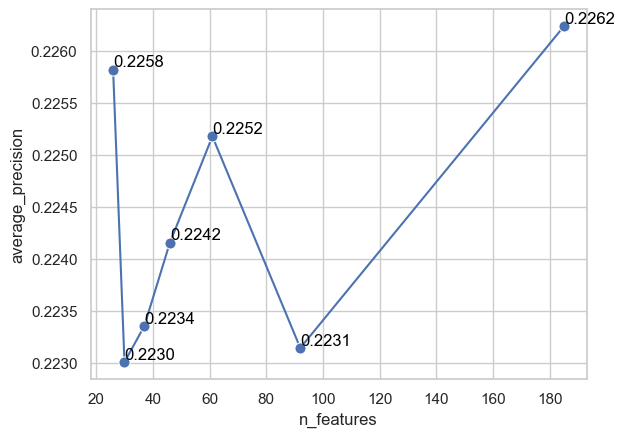

In [38]:
ax = sns.lineplot(x="n_features", y="average_precision", data=rfe_results, marker='o', markersize=8)
for i, row in rfe_results.iterrows():
    ax.text(row['n_features'], row['average_precision'], f'{row["average_precision"]:.4f}', color='black', ha='left', va='bottom')

plt.show()

Let's do some more feature engineering here. A good approach of feature creation in the context we are in (credit) is to compare the values of variables that could have interesting relationships. For example, the new feature CREDIT_INCOME compares the amount of credit and the total income of the client: could the client that asks for too much credit compared to their total income present more chances to default?

Some these features created below need the "1 +" in order to prevent division by zero.

In [8]:
df3["CREDIT_INCOME"] = (1 + df3["AMT_CREDIT"]) / (1 + df3["AMT_INCOME_TOTAL"])
df3["ANNUITY_INCOME"] = (1 + df3["AMT_ANNUITY"]) / (1 + df3["AMT_INCOME_TOTAL"])
df3["CREDIT_GOODS_PRICE"] = (1 + df3["AMT_CREDIT"]) / (1 + df3["AMT_GOODS_PRICE"])
df3["GOODS_PRICE_INCOME"] = (1 + df3["AMT_GOODS_PRICE"]) / (1 + df3["AMT_INCOME_TOTAL"])
df3["EXTS_2_3_DIFF"] = df3["EXT_SOURCE_2"] - df3["EXT_SOURCE_3"]
df3["EXTS_2_3_MEAN"] = (df3["EXT_SOURCE_2"] + df3["EXT_SOURCE_3"]) / 2
df3["EXTS_2_3_SUM"] = df3["EXT_SOURCE_2"] + df3["EXT_SOURCE_3"]

In [40]:
df3

,SK_ID_CURR,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,NAME_CONTRACT_TYPE,NAME_TYPE_SUITE,NAME_EDUCATION_TYPE,NAME_HOUSING_TYPE,N_ACTIVE,N_SOLD,N_CLOSED,N_BADD,N_DICT_BUREAU_CREDS,MAX_DAYS_CREDIT,AVG_DAYS_CREDIT,MAX_CREDIT_DAY_OVERDUE,AVG_DAYS_CREDIT_ENDDATE,AVG_DAYS_ENDDATE_FACT,MAX_AMT_CREDIT_MAX_OVERDUE,AVG_AMT_CREDIT_MAX_OVERDUE,SUM_AMT_CREDIT_MAX_OVERDUE,MAX_CNT_CREDIT_PROLONG,AVG_AMT_CREDIT_SUM,MAX_AMT_CREDIT_SUM,SUM_AMT_CREDIT_SUM,AVG_AMT_CREDIT_SUM_DEBT,MAX_AMT_CREDIT_SUM_DEBT,SUM_AMT_CREDIT_SUM_DEBT,MAX_AMT_CREDIT_SUM_LIMIT,AVG_AMT_CREDIT_SUM_OVERDUE,MAX_AMT_CREDIT_SUM_OVERDUE,SUM_AMT_CREDIT_SUM_OVERDUE,AVG_AMT_AMT_ANNUITY,MAX_AMT_AMT_ANNUITY,SUM_AMT_AMT_ANNUITY,TARGET,CREDIT_INCOME,ANNUITY_INCOME,CREDIT_GOODS_PRICE,GOODS_PRICE_INCOME,EXTS_2_3_DIFF,EXTS_2_3_MEAN,EXTS_2_3_SUM
0,100249,67500.0,76410.0,4513.5,67500.0,0.010500,-15293,-5317,-4699.0,-4753,0.0,1,1,1,1,0,0,Laborers,4.0,3,3,15,0,0,0,0,1,1,1,0.636498,0.093445,0.519097,0.0340,0.0000,0.9816,0.0000,0.0000,0.00,0.0000,0.0833,0.0000,0.0000,0.0000,0.0269,0.0000,0.0000,0.0347,0.0000,0.9816,0.0000,0.0000,0.0000,0.0000,0.0833,0.0000,0.0000,0.0000,0.0281,0.0000,0.0000,0.0344,0.0000,0.9816,0.0000,0.0000,0.00,0.0000,0.0833,0.0000,0.0000,0.0000,0.0274,0.0000,0.0000,No Data,No Data,0.0212,"Stone, brick",No,0.0,0.0,0.0,0.0,-1655.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,1.0,0.0,0,N,Y,2.0,Cash loans,Unaccompanied,0,House / apartment,1.0,0.0,2.0,0.0,3.0,-550.0,-682.333333,0.0,-86.000000,-421.000000,0.00,0.000,0.000,0.0,117321.000000,270000.0,351963.00,1512.000000,4536.000,4536.000,0.000,0.0,0.0,0.0,0.000000,0.0,0.0,0,1.131998,0.066880,1.131998,1.000000,-0.425652,0.306271,0.612543
1,274024,112500.0,720000.0,21181.5,720000.0,0.009334,-18721,365243,-6134.0,-2251,0.0,1,0,0,1,1,0,No Data,2.0,2,2,10,0,0,0,0,0,0,0,0.832720,0.625494,0.634706,0.0000,0.0000,0.0000,0.0000,0.0000,0.00,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,

## Choosing the Algorithm

We have now all features we need. Let's proceed with choosing the algorithm to build the model afterwards. We are going to test multiple models, such as: Random Forest, LightGBM, XBGoost and various Stacked models using such algorithms.

Stratified cross-validation will be used to check the best model and the metrics measured are ROC AUC, Precision and Recall (standard threshold).

  File "c:\Users\artur\Documents\home_credit_model\.venv\Lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


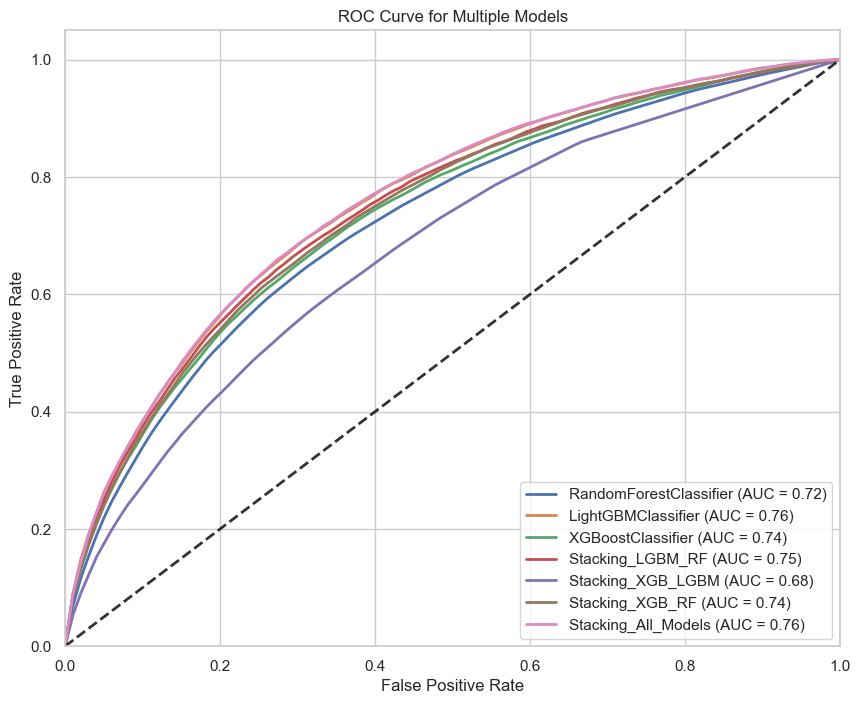

In [41]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

features = [c for c in df3.columns if c not in ['TARGET', 'SK_ID_CURR']]
string_cols = [c for c in list(df3.columns) if df3[c].dtype == 'object']

x_input = df3[features]
y_output = df3["TARGET"]

ratio = float(y_output.value_counts()[0]) / y_output.value_counts()[1]

columns_trans = ColumnTransformer(
    transformers=[
        ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first'), string_cols)
    ],
    remainder='passthrough'
)

k = 3
kf = StratifiedKFold(n_splits=k)

models = {
    "RandomForestClassifier": RandomForestClassifier(class_weight='balanced', n_jobs=-1, random_state=42),
    "LightGBMClassifier": LGBMClassifier(verbose=-1, scale_pos_weight=ratio, random_state=42),
    "XGBoostClassifier": XGBClassifier(scale_pos_weight=ratio, random_state=42)
}

stacking_models = {
    "Stacking_LGBM_RF": StackingClassifier(
        estimators=[
            ('rf', RandomForestClassifier(class_weight='balanced', n_jobs=-1, random_state=42)),
            ('lgbm', LGBMClassifier(verbose=-1, scale_pos_weight=ratio, random_state=42))
        ],
        final_estimator=XGBClassifier(scale_pos_weight=ratio, random_state=42)
    ),
    "Stacking_XGB_LGBM": StackingClassifier(
        estimators=[
            ('xgb', XGBClassifier(scale_pos_weight=ratio, random_state=42)),
            ('lgbm', LGBMClassifier(verbose=-1, scale_pos_weight=ratio, random_state=42))
        ],
        final_estimator=RandomForestClassifier(class_weight='balanced', n_jobs=-1, random_state=42)
    ),
    "Stacking_XGB_RF": StackingClassifier(
        estimators=[
            ('xgb', XGBClassifier(scale_pos_weight=ratio, random_state=42)),
            ('rf', RandomForestClassifier(class_weight='balanced', n_jobs=-1, random_state=42))
        ],
        final_estimator=LGBMClassifier(verbose=-1, scale_pos_weight=ratio, random_state=42)
    ),
    "Stacking_All_Models": StackingClassifier(
        estimators=[
            ('rf', RandomForestClassifier(class_weight='balanced', n_jobs=-1, random_state=42)),
            ('lgbm', LGBMClassifier(verbose=-1, scale_pos_weight=ratio, random_state=42)),
            ('xgb', XGBClassifier(scale_pos_weight=ratio, random_state=42))
        ],
        final_estimator=LogisticRegression()
    )
}

models.update(stacking_models)

metrics = ["Precision", "ROC_AUC", "Recall"]

model_metrics = {}
plt.figure(figsize=(10, 8))

for model_name, model in models.items():
    fold_metrics = {metric: [] for metric in metrics}
    tprs = []
    mean_fpr = np.linspace(0, 1, 100)
    for train_index, val_index in kf.split(x_input, y=y_output):
        X_train_fold, X_val_fold = x_input.iloc[train_index], x_input.iloc[val_index]
        y_train_fold, y_val_fold = y_output.iloc[train_index], y_output.iloc[val_index]

        pipeline = make_pipeline(columns_trans, model)
        pipeline.fit(X_train_fold, y_train_fold.values.ravel())

        y_pred_prob = pipeline.predict_proba(X_val_fold)[:, 1]
        
        fpr, tpr, _ = roc_curve(y_val_fold, y_pred_prob)
        roc_auc = auc(fpr, tpr)
        
        tprs.append(np.interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        
        precision = precision_score(y_val_fold, pipeline.predict(X_val_fold))
        recall = recall_score(y_val_fold, pipeline.predict(X_val_fold))
        roc_auc_metric = float(roc_auc_score(y_val_fold, pipeline.predict_proba(X_val_fold)[:, 1]))
        
        fold_metrics["Precision"].append(precision)
        fold_metrics["ROC_AUC"].append(roc_auc_metric)
        fold_metrics["Recall"].append(recall)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    
    plt.plot(mean_fpr, mean_tpr, label=f'{model_name} (AUC = {mean_auc:.2f})', lw=2)

    mean_metrics = {
        metric: [float(np.mean(fold_metrics[metric])), float(np.std(fold_metrics[metric], ddof=1))]
        for metric in metrics
    }
    model_metrics[model_name] = mean_metrics

plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='black', alpha=.8)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multiple Models')
plt.legend(loc="lower right")
plt.show()


As we can see above and below, the Stacked model considering LightGBM, XBGoost and Random Forest as base learners and Logistic Regression as meta learner, mainly based on the ROC AUC metric (the metric we are going to interpret as the main one to guide our modeling).

In [42]:
with open("cv_results.json", "w") as json_file:
        json.dump(model_metrics, json_file)

In [43]:
rows = []

for model, metrics in model_metrics.items():
    for metric, value in metrics.items():
        rows.append([model, metric, value[0], value[1]])

metrics_df = pd.DataFrame(rows, columns=['Model name', 'Metric name', 'Metric Mean value', 'Metric Std value'])

In [44]:
metrics_df

,Model name,Metric name,Metric Mean value,Metric Std value
0,RandomForestClassifier,Precision,0.521709,0.053985
1,RandomForestClassifier,ROC_AUC,0.723409,0.006126
2,RandomForestClassifier,Recall,0.004986,0.000775
3,LightGBMClassifier,Precision,0.172359,0.002200
4,LightGBMClassifier,ROC_AUC,0.757210,0.002823
5,LightGBMClassifier,Recall,0.658083,0.009861
6,XGBoostClassifier,Precision,0.184342,0.001690
7,XGBoostClassifier,ROC_AUC,0.736895,0.002271
8,XGBoostClassifier,Recall,0.552830,0.009195
9,Stacking_LGBM_RF,Precision,0.162089,0.001559


## Hyperparameter Tunning

Let's then proceed to tunning the hyperparameters. Since we have a limited machine here, we are going to only tune in each algorithm the hyperparameter related to the weight given to the minority class during training. BayesSearchCV will be used with k = 3 and the metric is ROC AUC.

In [ ]:
features = [c for c in df3.columns if c not in ['TARGET', 'SK_ID_CURR']]
string_cols = [c for c in list(df3.columns) if df3[c].dtype == 'object']

x_input = df3[features]
y_output = df3["TARGET"]

ratio = float(y_output.value_counts()[0]) / y_output.value_counts()[1]

X_train, X_val, y_train, y_val = train_test_split(x_input, y_output, test_size=0.25, random_state=42, stratify=y_output)

columns_trans = ColumnTransformer(
    transformers=[
        ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first'), string_cols)
    ],
    remainder='passthrough'
)

stacking_model = StackingClassifier(
    estimators=[
        ('rf', RandomForestClassifier(n_jobs=-1, random_state=42)),
        ('lgbm', LGBMClassifier(random_state=42, verbose=-1)),
        ('xgb', XGBClassifier(random_state=42))
    ],
    final_estimator=LogisticRegression()
)

pipeline = Pipeline(steps=[
    ('preprocessor', columns_trans),
    ('classifier', stacking_model)
])

params = {
    'classifier__rf__class_weight': [None, 'balanced'],
    'classifier__lgbm__scale_pos_weight': [1, ratio],
    'classifier__xgb__scale_pos_weight': [1, ratio]
}

grid_search = BayesSearchCV(estimator=pipeline, search_spaces=params, cv=StratifiedKFold(n_splits=3), n_jobs=-1, scoring='roc_auc', random_state=42)
grid_search.fit(X_train, y_train.values.ravel())

print("\nBest Hyperparameters according to BayesSearch for Stacking Classifier:", grid_search.best_params_)

best_model = grid_search.best_estimator_
best_model.fit(X_train, y_train.values.ravel())

y_pred = best_model.predict(X_val)
y_pred_proba = best_model.predict_proba(X_val)[:, 1]

roc_auc = roc_auc_score(y_val, y_pred_proba)
precision = precision_score(y_val, y_pred)
recall = recall_score(y_val, y_pred)

print(f"ROC AUC: {roc_auc}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")

conf_matrix = confusion_matrix(y_val, y_pred)
print("\nConfusion Matrix:")
print(conf_matrix)

Best Hyperparameters according to BayesSearch for Stacking Classifier: OrderedDict([('classifier__lgbm__scale_pos_weight', 5.935329462897532), ('classifier__rf__class_weight', None), ('classifier__xgb__scale_pos_weight', 7.5119405654163165)])


ROC AUC: 0.7610324666727969

Precision: 0.6272727272727273

Recall: 0.018852459016393444


Confusion Matrix:

[[41854    41]

 [ 3591    69]]

Above, one can see that the best hyperparameters resulted in a ROC AUC of 0.761, a decent Precision and a terrible Recall. In order to improve Precision and Recall, we need some more modeling.

In [9]:
string_cols = [c for c in list(df3.columns) if df3[c].dtype == 'object']

columns_trans = ColumnTransformer(
    transformers=[
        ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first'), string_cols)
    ],
    remainder='passthrough'
)

stacking_model = StackingClassifier(
    estimators=[
        ('rf', RandomForestClassifier(n_jobs=-1, random_state=42, class_weight=None)),
        ('lgbm', LGBMClassifier(random_state=42, verbose=-1, scale_pos_weight=5.935329462897532)),
        ('xgb', XGBClassifier(random_state=42, scale_pos_weight=7.5119405654163165))
    ],
    final_estimator=LogisticRegression()
)

pipeline = Pipeline(steps=[
    ('preprocessor', columns_trans),
    ('classifier', stacking_model)
])

In [10]:
string_cols = [c for c in list(df3.columns) if df3[c].dtype == 'object']
features = [c for c in df3.columns if c not in ['TARGET', 'SK_ID_CURR']]

x_input = df3[features]
y_output = df3["TARGET"]

X_train, X_val, y_train, y_val = train_test_split(x_input, y_output, test_size=0.15, random_state=42, stratify=y_output)

pipeline.fit(X_train, y_train.values.ravel())

  File "c:\Users\artur\Documents\home_credit_model\.venv\Lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehot',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['OCCUPATION_TYPE',
                                                   'REGION_RATING_CLIENT',
                                                   'REGION_RATING_CLIENT_W_CITY',
                                                   'FONDKAPREMONT_MODE',
                                                   'HOUSETYPE_MODE',
                                                   'WALLSMATERIAL_MODE',
                                                   'EMERGENCYSTATE_MODE',
                                                   'FLAG_OWN_CAR',
                                                   'FLAG_OWN_REALTY',
                                                   'NAME_CONTRACT...
                                                               interaction_constraints=None,
                                                               learning_rate=None,
                                                               max_bin=None,
                                                               max_cat_threshold=None,
                                                               max_cat_to_onehot=None,
                                                               max_delta_step=None,
                                                               max_depth=None,
                                                               max_leaves=None,
                                                               min_child_weight=None,
                                                               missing=nan,
                                                               monotone_constraints=None,
                                                               multi_strategy=None,
                                                               n_estimators=None,
                                                               n_jobs=None,
                                                               num_parallel_tree=None,
                                                               random_state=42, ...))],
                                    final_estimator=LogisticRegression()))])

## Probability Calibration and Threshold Tunning

In the following cells, we are basically performing 3 steps: creating a baseline of the metrics with only the tunned model, then proceeding with the probability calibration of the model's predictions and stating the new performance and finally doing threshold tunning and stating the new performance. With all this, we will have metrics to compare along every new improvement.

In [11]:
y_pred = pipeline.predict(X_val)
y_pred_proba = pipeline.predict_proba(X_val)[:, 1]

roc_auc = roc_auc_score(y_val, y_pred_proba)
precision = precision_score(y_val, y_pred)  
recall = recall_score(y_val, y_pred)

print("=====================================")
print("Prediction results with: Hyperparameter Tunning")
print(f"ROC AUC: {roc_auc}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")

conf_matrix = confusion_matrix(y_val, y_pred)
print("\nConfusion Matrix:")
print(conf_matrix)
print("=====================================")

Prediction results with: Hyperparameter Tunning
ROC AUC: 0.764003008504289
Precision: 0.6835443037974683
Recall: 0.02459016393442623

Confusion Matrix:
[[25112    25]
 [ 2142    54]]


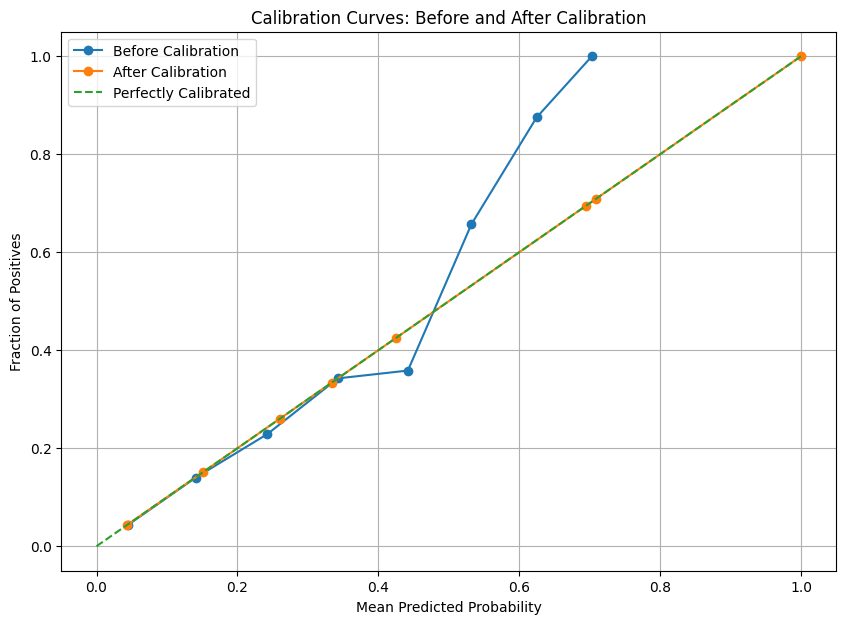

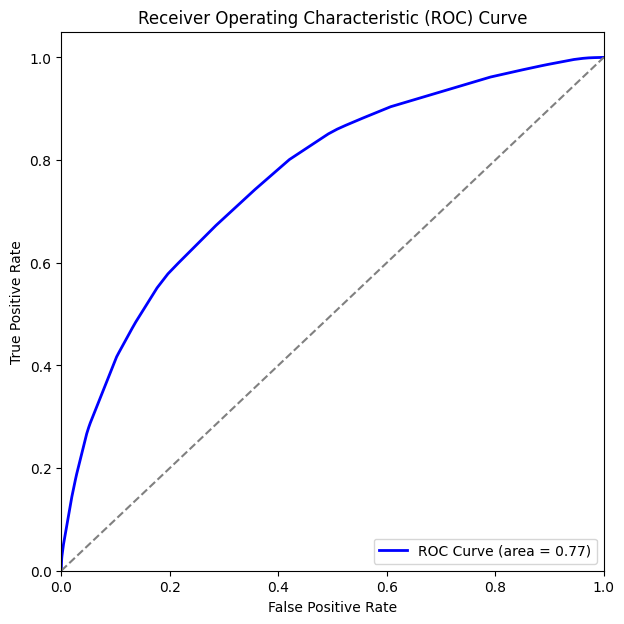

In [12]:
# Step 3: Predict probabilities before calibration
y_pred_proba_before = pipeline.predict_proba(X_val)[:, 1]

# Step 4: Calibration using isotonic regression
calibrator = CalibratedClassifierCV(estimator=pipeline, method='isotonic', cv='prefit')
calibrator.fit(X_val, y_val)

# Step 5: Predict probabilities after calibration
y_pred_proba_after = calibrator.predict_proba(X_val)[:, 1]

# Step 6: Plot Calibration Curves before and after calibration
plt.figure(figsize=(10, 7))

# Calibration curve (before)
prob_true_before, prob_pred_before = calibration_curve(y_val, y_pred_proba_before, n_bins=10)
plt.plot(prob_pred_before, prob_true_before, marker='o', label='Before Calibration')

# Calibration curve (after)
prob_true_after, prob_pred_after = calibration_curve(y_val, y_pred_proba_after, n_bins=10)
plt.plot(prob_pred_after, prob_true_after, marker='o', label='After Calibration')

# Reference line (Perfect calibration)
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly Calibrated')

plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title('Calibration Curves: Before and After Calibration')
plt.legend()
plt.grid(True)
plt.show()

# Step 7: Plot ROC Curve
fpr, tpr, _ = roc_curve(y_val, y_pred_proba_after)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(7, 7))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


In [13]:
y_pred = calibrator.predict(X_val)
y_pred_proba = calibrator.predict_proba(X_val)[:, 1]

roc_auc = roc_auc_score(y_val, y_pred_proba)
precision = precision_score(y_val, y_pred)  
recall = recall_score(y_val, y_pred)

print("=====================================")
print("Prediction results with: Hyperparameter Tunning + Prob Calibration")
print(f"ROC AUC: {roc_auc}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")

conf_matrix = confusion_matrix(y_val, y_pred)
print("\nConfusion Matrix:")
print(conf_matrix)
print("=====================================")

Prediction results with: Hyperparameter Tunning + Prob Calibration
ROC AUC: 0.7665530959558378
Precision: 0.7352941176470589
Recall: 0.022768670309653915

Confusion Matrix:
[[25119    18]
 [ 2146    50]]


In [14]:
# Get predicted probabilities from the calibrated model
y_pred_proba_calibrated = calibrator.predict_proba(X_val)[:, 1]

# Calculate precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_val, y_pred_proba_calibrated)

beta = 1

# Find the optimal threshold where precision and recall are balanced

fbeta_scores = (1 + beta**2) * (precision * recall) / (beta**2 * precision + recall)

#f1_scores = 2 * (precision * recall) / (precision + recall)
best_threshold = thresholds[np.argmax(fbeta_scores)]

print(f"Optimal Threshold: {best_threshold}")

Optimal Threshold: 0.18816489361702127


In [15]:
y_proba = calibrator.predict_proba(X_val)[:, 1]
y_pred = np.where(y_proba >= best_threshold, 1, 0)

roc_auc = roc_auc_score(y_val, y_proba)
precision = precision_score(y_val, y_pred)  
recall = recall_score(y_val, y_pred)

print("=====================================")
print("Prediction results with: Hyperparameter Tunning + Prob Calibration + Threshold Tunning")
print(f"ROC AUC: {roc_auc}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")

conf_matrix = confusion_matrix(y_val, y_pred)
print("\nConfusion Matrix:")
print(conf_matrix)
print("=====================================")

Prediction results with: Hyperparameter Tunning + Prob Calibration + Threshold Tunning
ROC AUC: 0.7665530959558378
Precision: 0.2630066110951423
Recall: 0.4166666666666667

Confusion Matrix:
[[22573  2564]
 [ 1281   915]]


We can see that, in the end, we improved our Recall (followed by a decrease in Precision) by using the probability threshold of 0.188 obtained by find the threshold that provides the max F-beta (with beta = 1) score. With beta equal to 1, we are trying to find a balance between precision and recall equally.

This is not the best result, but it provides a decent balance between precison and recall and provides good probabilities since the ROC AUC score has a satisfatory value of 0.77.

### =============================================

## Final Training and Testing on Unseen Data

A function called 'feature_engineering_training' was created to make all the transformation steps stated in this notebook before training the mode, along with another function named 'feature_engineering_production' that applies the same steps but in the context of applying predictions in production situations. StackedModel comes from a method that has this class and defines the model object and its functions.

So, below we do two final tests: train the model built until now and check its performance on training data and apply the trained model to predict new unseen data to check how it performs.

In [7]:
df = pd.read_csv(r'C:\Users\artur\Documents\home_credit_model\data\training_data_nb.csv')
df_train = feature_engineering_training(df)

y_val = df_train['TARGET'].values

model = StackedModel(df_train).train_model()

y_proba, y_pred = StackedModel(df_train).prediction_w_model(model)

roc_auc = roc_auc_score(y_val, y_proba)
precision = precision_score(y_val, y_pred)
recall = recall_score(y_val, y_pred)

print("=====================================")
print("Prediction results with on Training Data")
print(f"ROC AUC: {roc_auc}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")

conf_matrix = confusion_matrix(y_val, y_pred)
print("\nConfusion Matrix:")
print(conf_matrix)
print("=====================================")

  File "c:\Users\artur\Documents\home_credit_model\.venv\Lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


Prediction results with on Training Data
ROC AUC: 0.9341891577629426
Precision: 0.4807387623919243
Recall: 0.725360289597705

Confusion Matrix:
[[156107  11471]
 [  4021  10620]]


In [16]:
df = pd.read_csv(r'C:\Users\artur\Documents\home_credit_model\data\testing_data_nb.csv').drop_duplicates()
df_test = feature_engineering_production(df)

y_val = df_test['TARGET'].values

y_proba, y_pred = StackedModel(df_test).prediction_w_model(model)

df_test['predicted'] = y_pred

financial_impact = df_test.loc[(df_test['TARGET']==1) & (df_test['predicted']==1)]['AMT_CREDIT'].sum()

print("=====================================")
print("Prediction results with on Training Data")
print(f'Financial impact of the model:{round(financial_impact,2)} USD')
print("=====================================")

roc_auc = roc_auc_score(y_val, y_proba)
precision = precision_score(y_val, y_pred)  
recall = recall_score(y_val, y_pred)

print("\n=====================================")
print("Prediction results with on Training Data")
print(f"ROC AUC: {roc_auc}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")

conf_matrix = confusion_matrix(y_val, y_pred)
print("\nConfusion Matrix:")
print(conf_matrix)
print("=====================================")

Prediction results with on Training Data
Financial impact of the model:1373786928.0 USD

Prediction results with on Training Data
ROC AUC: 0.8496794590165433
Precision: 0.3717575051005538
Recall: 0.5567437800087298

Confusion Matrix:
[[48350  4311]
 [ 2031  2551]]


We got a ROC AUC of 0.934 on training data and a ROC AUC of 0.850 on testing data. Very nice results on the unseen data! On the testing data we also got more than half of the positive class rows correctly, as we can see by looking at the Recall of 0.56.

Along with these good results, we can also calculate the financial impact of the predictions. If the client has a positive (default) target and we correctly predicted that it was a default, we can consider the credit amount of the transaction of that client as something the model predicted and therefore could prevent the occurrence. With this, considering the test data, we would have a financial impact of: 

### 1373786928.0 USD

Wow! Amazing impact. The model works and adds value to the company!